In [ ]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
from keras import Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Generating hand-writing
Using cGAN - conditional generative adversarial network based on MNIST and EMNIST datasets.

#### Model initiation and preprocessing
As data pre-processing in the clasicall meaning of this term was not required we have took Frederiks' example Generative adversarial network <br>from the classroom and took is (as it was intended) as our starting point.<br>
It quickly bacame apparent why, are we required to use cGAN (Conditional GAN) and so me moved to refactoring the code.<br>
Here, are few of the most important things that we would like to point out in the beginning:<br>
- The choice of conditioning done on labels -> the generatos takes a noise vector and a class label which is embedded and concatenated to the noise<br>
- The discriminator takes and image and a class label concatenating them before classification.<br>
This approach dictates following, very specific way of preparing the data as well as specific implementation of the train_step() method.<br>
- The data, X and y where converted to respectively float34 and int64<br>
- The labels (labels for the letters) were converted into a one-hot encoded vector<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


X = np.load('/content/drive/My Drive/' + 'x_letters.npy')
y = np.load('/content/drive/My Drive/' + 'y_letters.npy')

X = X.astype(np.float32)
y = y.astype(np.int64)
y = keras.utils.to_categorical(y, num_classes=26)
#zipped_data = tf.data.Dataset.from_tensor_slices((X, y))

#print(Y[0:10])

Mounted at /content/drive


#### Shape, rescaling, dataset, shuffling and batching
- Shape confirms the dimensions of our dataset.<br>
- printing dtype confirmss the correctness of the previously mentioned conversion.<br>
- X.min() and X.max() checks the pixel intensity range
- Rescaling was done when we realized our data x had range [0,1] -> GANs and cGANs, in theory, should work better with the range [-1,1].<br>
- Previously mentioned change should also stabilize the training of our model if we use tahn activation on the generator (which we are doing).<br>
- Than we converted the features and labels into a Tensorflow dataset.<br>
- That change was done so we could have two inputs for discriminator and generator as mentioned in the introduction.<br>
- Shuffle is randomizing the dataset order (because the data was originally in the alphabetical order). This choice prevents overfitting to a specific order of the letters and any bias.<br>
- Batching is a logical choice for faster training.<br>

In [ ]:
print(X.shape)
print(X.dtype, X.min(), X.max())

X = 2 * X- 1

print(X.shape)
print(X.dtype, X.min(), X.max())

zipped_data = tf.data.Dataset.from_tensor_slices((X, y))
zipped_data = zipped_data.shuffle(buffer_size=len(X)).batch(32)

(88799, 28, 28)
float32 0.0 1.0
(88799, 28, 28)
float32 -1.0 1.0


#### Class Labels, model metrics and Training Step
The class definition and initialization does following things:<br>
- Stores the discrimnator and generator models
- Defines latent_dim -> the size of the noise vector that we input to our generator.<br>
- Stores rendom SeedGenerator that serves to create reandomness and ensure consistent training behaviour.<br>
Model metrics - we are tracking two things: d_loss and g_loss.<br>
Overview of training step (step by step):<br>
- We are using the generator to create fake images.<br>
- Combining real and fake images.<br>
- Putting the images with their corresponing labels and creating target labels: 1 for the real images and 0 for the fake images.<br>
- Applying label noise:<br>
    - It is preventing the discriminator from becoming too good.<br>
    - It is making the lables slightly more noisy.<br>
- Train the discriminator and the generator:<br>
- At last, we are tracking loss values and logging them.<br>

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(2137)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_data):
       real_images, real_classes = real_data

       batch_size = ops.shape(real_images)[0]
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim),
           seed=self.seed_generator
       )

       #create images out of random vectors
       generated_images = self.generator([random_latent_vectors, real_classes])

       #combine with real images
       combined_images = ops.concatenate([generated_images, real_images], axis = 0)
       combined_classes = ops.concatenate([real_classes, real_classes], axis = 0)

       labels = ops.concatenate(
           [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis = 0
       )
       #add noise to the labels - important trick!
       #basically makes sure the discriminator is not perfect
       #so the generator has a chance to learn
       labels += 0.05*tf.random.uniform(tf.shape(labels))

       #train the discriminator
       with tf.GradientTape() as tape:
          predictions = self.discriminator([combined_images, combined_classes])
          d_loss = self.loss_fn(labels, predictions)
       grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
       self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

       #sample random points in latent space
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim),
           seed=self.seed_generator

       )

       #misleading labels saying "all real"
       misleading_labels = ops.zeros((batch_size, 1))

       #train generator (don't touch the weights of the discriminator)
       with tf.GradientTape() as tape:
          gened_imgs = self.generator([random_latent_vectors, real_classes])
          predictions = self.discriminator([gened_imgs, real_classes])
          g_loss = self.loss_fn(misleading_labels, predictions)
       grads = tape.gradient(g_loss, self.generator.trainable_weights)
       self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

       #update metrics
       self.d_loss_metric.update_state(d_loss)
       self.g_loss_metric.update_state(g_loss)
       return {
           "d_loss" : self.d_loss_metric.result(),
           "g_loss" : self.g_loss_metric.result(),
       }

#### GANMonitor and epochs
The monitors main purpose is tracking the learning progress:<br>
- tracking d_loss and g_loss<br>
- logging the values every 10 epochs<br>
- plotting the loss curves at the end of the training<br>

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.d_losses = []
        self.g_losses = []

    def on_epoch_end(self, epoch, logs=None):
        d_loss = logs.get("d_loss", 0)
        g_loss = logs.get("g_loss", 0)

        self.d_losses.append(d_loss)
        self.g_losses.append(g_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: d_loss = {d_loss:.4f}, g_loss = {g_loss:.4f}")

    def on_train_end(self, logs=None):
        plt.figure(figsize=(10,5))
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.plot(self.g_losses, label="Generator Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("GAN Training Losses")
        plt.show()


#### TRAINING
cGANs definition of latent_dim for the generator.<br>
The generator takes a 256-dimensional noise vector for input.<br>
GENERATOR Model:<br>
- 2 inputs:<br>
    - noisy_input -> additionally we added Gaussian noise on the noise_input<br>
    - we concatenate the label embedding with the noise vector<br>
- We are passing it through 4 Dense layers (128,256,512,1024) with LeakyReLU activation on 0.2<br>
    - Choice of LeakyReLU prevents dead neurons and batch normalization stabilizes the training.<br>
- Final layer is producing 784 output neurons (28x28 image) using Tahn activation (the choice of it was explained earlier).<br>

DISCRIMINATOR Model:<br>
- 2 inputs:<br>
    - 28x28 grayscale image (fake or real)<br>
    - one-hot encoded labels (26 classes as 26 letters)<br>
- Flatten -> images are flattened into a vector<br>
- We are concatenating the image vector with the label vector.<br>
- We are passing through 3 Dense layers (512,256,128) with LeakyReLU activation on 0.2 again<br>
    - The choice of LeakyReLU gives us more stability in the discriminator
    - Dropout and Batch normalization serves for respectively preventing overfitting and for stabilization<br>
- Final layer is using single neuron with Sigmoid activation.<br>

TRAINING:<br>
- After creating instances of the generator and discriminator we are training for 500 epochs.<br>
- We are creating our cGAN model including:<br>
    - Adam optimizer for both networks.<br>
        - Generator has learning rate of 0.0002<br>
        - Discriminator has learning rate of 0.0001<br>
    - Gradient clipping is used because we would like to prevent exploding gradients.<br>
    - We are using Binary CrossEntropy loss.<br>
    - We are training the model using out zipped_data dataset (see the previous explanation)<br>
    - And lastly we are including our monitor as a callback for logging and plot the graphs of the losses.<br>

Epoch 1/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - d_loss: 0.8061 - g_loss: 1.0449Epoch 0: d_loss = 0.6903, g_loss = 0.9965
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - d_loss: 0.8061 - g_loss: 1.0449
Epoch 2/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - d_loss: 0.5965 - g_loss: 1.0648
Epoch 3/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - d_loss: 0.5414 - g_loss: 1.2651
Epoch 4/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - d_loss: 0.5328 - g_loss: 1.3235
Epoch 5/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - d_loss: 0.5422 - g_loss: 1.3115
Epoch 6/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - d_loss: 0.5347 - g_loss: 1.3438
Epoch 7/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - d_loss: 0.5367 - g_loss: 1.3483
Epoch 8/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - d_loss: 0.5417 - g_loss: 1.3402
Epoch 9/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - d_loss: 0.5377 - g_loss: 1.3557
Epoch 10/500
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - d_loss: 0.5388 - g_los

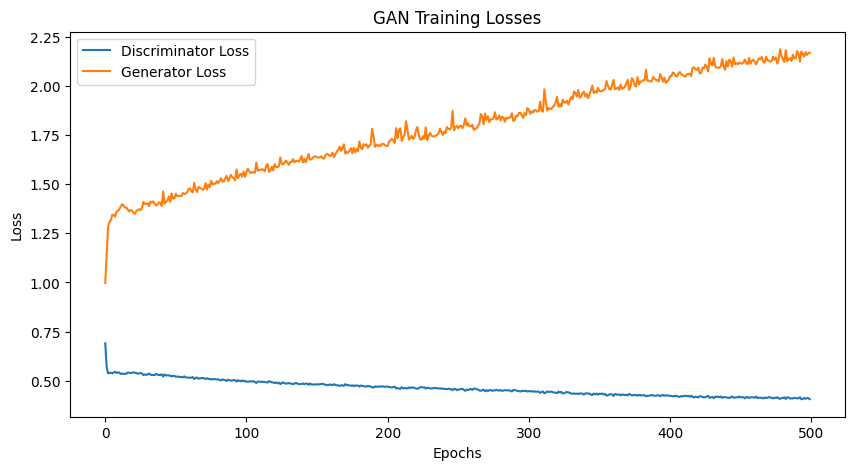

In [6]:
latent_dim = 256

def build_generator():
    noisy_input = Input(shape=(latent_dim,), name="noisy_input")
    noisy_input = layers.GaussianNoise(0.1)(noisy_input)
    label_input = Input(shape=(26,), name="label_input")

    label_indices = layers.Lambda(lambda x: tf.argmax(x, axis=1))(label_input)

    label_embedding = layers.Embedding(input_dim=26, output_dim=10, name="label_embedding")(label_indices)
    label_embedding = layers.Flatten()(label_embedding)

    gen = layers.Concatenate(axis=-1)([noisy_input, label_embedding])
    gen = layers.Dense(128, kernel_initializer="he_normal", use_bias=False)(gen)
    gen = layers.LeakyReLU(0.2)(gen)
    gen = layers.BatchNormalization(momentum=0.8)(gen)
    gen = layers.Dense(256, kernel_initializer="he_normal", use_bias=False)(gen)
    gen = layers.LeakyReLU(0.2)(gen)
    gen = layers.BatchNormalization(momentum=0.8)(gen)
    gen = layers.Dense(512, kernel_initializer="he_normal", use_bias=False)(gen)
    gen = layers.LeakyReLU(0.2)(gen)
    gen = layers.BatchNormalization(momentum=0.8)(gen)
    gen = layers.Dense(1024, kernel_initializer="he_normal", use_bias=False)(gen)
    gen = layers.LeakyReLU(0.2)(gen)
    gen = layers.BatchNormalization(momentum=0.8)(gen)
    gen = layers.Dense(784, activation="tanh")(gen)
    out = layers.Reshape((28, 28))(gen)

    return keras.Model(inputs=[noisy_input, label_input], outputs=out)

def build_discriminator():
    img_input = keras.Input(shape=(28,28), name="img_input")
    label_input = keras.Input(shape=(26,), name="label_input")

    flat_image = layers.Flatten()(img_input)
    dis = layers.Concatenate(axis=-1)([flat_image, label_input])
    dis = layers.Dense(512, kernel_initializer="he_normal")(dis)
    dis = layers.LeakyReLU(0.2)(dis)
    dis = layers.Dropout(0.3)(dis)
    dis = layers.BatchNormalization(momentum=0.8)(dis)
    dis = layers.Dense(256, kernel_initializer="he_normal")(dis)
    dis = layers.LeakyReLU(0.2)(dis)
    dis = layers.Dropout(0.3)(dis)
    dis = layers.BatchNormalization(momentum=0.8)(dis)
    dis = layers.Dense(128, kernel_initializer="he_normal")(dis)
    dis = layers.LeakyReLU(0.2)(dis)
    dis = layers.Dropout(0.3)(dis)
    dis = layers.BatchNormalization(momentum=0.8)(dis)

    out = layers.Dense(1, activation="sigmoid")(dis)

    return keras.Model(inputs=[img_input, label_input], outputs=out)

"""
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(128, kernel_initializer="he_normal", use_bias=False),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(256, kernel_initializer="he_normal", use_bias=False),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(28*28, activation="sigmoid"),
        layers.Reshape((28, 28)),
    ],
    name="generator",
)

discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(256, kernel_initializer="he_normal"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.4),
        layers.Dense(128, kernel_initializer="he_normal"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.4),
        #layers.Dense(64, kernel_initializer="he_normal"),
        #layers.LeakyReLU(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
"""

epochs = 500
gen = build_generator()
dis = build_discriminator()

gan = GAN(discriminator=dis, generator=gen, latent_dim=latent_dim)
gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999, clipnorm=1.0),
    g_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999, clipnorm=1.0),
    #d_optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
    #g_optimizer = keras.optimizers.RMSprop(learning_rate=0.002),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(zipped_data, epochs=epochs, callbacks=[GANMonitor()])

#### Plotting the images
Using numbers of images to generate, trained generator model and dimensionality we can plot the images to visualize the effects of our cGAN.<br>
- We are creating a figure with the size dependent on the number of images.<br>
- Than looping through generated images<br>
- We are using grayscale colormap (the binary)
- We are also removing the axes so there are no extra lines or labels.<br>

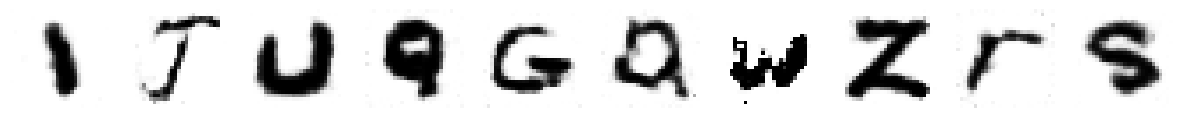

In [7]:
def plot_images(n_images, generator, latent_dim):
    random_latent_vectors = keras.random.normal(
            shape=(n_images, latent_dim),
            seed = keras.random.SeedGenerator(2137)
        )

    random_labels = tf.random.uniform(
        shape=(n_images,),
        minval=0,
        maxval=26,
        dtype=tf.int32
    )

    random_labels = tf.one_hot(random_labels, depth=26)

    images = generator([random_latent_vectors, random_labels])

    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
    plt.show()

plot_images(10, gen, latent_dim)

In [8]:
def generate_char(char):
    if char == ' ':
        return np.zeros((28, 28))

    num_chars = 26
    char_mapped = int(ord(char) - ord('a'))

    z = keras.random.normal(shape=(1, latent_dim), seed=keras.random.SeedGenerator(2137))
    one_hot_label = (ops.one_hot(char_mapped, num_classes=num_chars))
    one_hot_label = tf.expand_dims(one_hot_label, axis=0)

    generated_images = gen([z, one_hot_label])
    generated_images = generated_images.numpy()[0]

    return generated_images

In [9]:
"""def generate_text(text):
    images = [generate_char(c) for c in text]

    full_image = np.concatenate(images, axis=1)

    plt.imshow(full_image, cmap='gray_r')
    plt.axis('off')
    plt.show()"""

"def generate_text(text):\n    images = [generate_char(c) for c in text]\n\n    full_image = np.concatenate(images, axis=1)\n\n    plt.imshow(full_image, cmap='gray_r')\n    plt.axis('off')\n    plt.show()"

#### Printing words
Using variety of helper functions for:<br>
- generating char
- padding the images to the same height (for the reason if we wanted to generate very long 'hand-written' texts)<br>
- padding rows to the same width (same reason as above)<br>

We are finally moving to the generate text.<br>
We can clearly see that the whole alphabet is quite easy to read and there is not so much confusing letters.<br>
A,b,g,h are probably most confusing cause they sometimes look rather sloppily written. (hard to put it exactly to words)<br>

In [10]:
def pad_images_to_same_height(images):
    max_height = max(img.shape[0] for img in images)
    padded_images = [np.pad(img, ((0, max_height - img.shape[0]), (0, 0)), mode='constant') for img in images]
    return padded_images

def pad_rows_to_same_width(rows):
    max_width = max(row.shape[1] for row in rows)
    padded_rows = [np.pad(row, ((0, 0), (0, max_width - row.shape[1])), mode='constant') for row in rows]
    return padded_rows

def generate_text(text):
    images = [generate_char(c) for c in text]

    images_per_row = 45
    rows = [images[i:i + images_per_row] for i in range(0, len(images), images_per_row)]

    padded_rows = [pad_images_to_same_height(row) for row in rows]

    row_images = [np.concatenate(row, axis=1) for row in padded_rows]

    padded_row_images = pad_rows_to_same_width(row_images)

    full_image = np.concatenate(padded_row_images, axis=0)

    img_height, img_width = full_image.shape
    dpi = 100
    figsize = (img_width / dpi, img_height / dpi)

    plt.figure(figsize=figsize)
    plt.imshow(full_image, cmap='binary')
    plt.axis('off')
    plt.show()

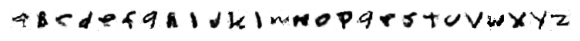

In [11]:
generate_text('abcdefghijklmnopqrstuvwxyz')

In [12]:
generate_text('in the beginning god created the heaven and the earth and the earth was without form and void and darkness was upon the face of the deep and the spirit of god moved upon the face of the waters and god said let there be light and there was light and god saw the light that it was good and god divided the light from the darkness and god called the light day and the darkness he called night and the evening and the morning were the first day and god said let there be a firmament in the midst of the waters and let it divide the waters from the waters and god made the firmament and divided the waters which were under the firmament from the waters which were above the firmament and it was so and god called the firmament Heavenand the evening and the morning were the second day and god said let the waters under the heaven be gathered together unto one place and let the dry land appear and it was so and god called the dry land earth and the gathering together of the waters called he seas and god saw that it was good and god said let the earth bring forth grass the herb yielding seed and the fruit tree yielding fruit after his kind whose seed is in itself upon the earth and it was so and the earth brought forth grass and herb yielding seed after his kind and the tree yielding fruit whose seed was in itself after his kind and god saw that it was good and the evening and the morning were the third day and god said let there be lights in the firmament of the heaven to divide the day from the night and let them be for signs and for seasons and for days and years and let them be for lights in the firmament of the heaven to give light upon the earth and it was so and god made two great lights the greater light to rule the day and the lesser light to rule the night he made the stars also and god set them in the firmament of the heaven to give light upon the earth and to rule over the day and over the night and to divide the light from the darkness and god saw that it was good and the evening and the morning were the fourth day and god said let the waters bring forth abundantly the moving creature that hath life and fowl that may fly above the earth in the open firmament of heaven and god created great whales and every living creature that moveth which the waters brought forth abundantly after their kind and every winged fowl after his kind and god saw that it was good and god blessed them saying be fruitful and multiply and fill the waters in the seas and let fowl multiply in the earth and the evening and the morning were the fifth day and god said let the earth bring forth the living creature after his kind cattle and creeping thing and beast of the earth after his kind and it was so and god made the beast of the earth after his kind and cattle after their kind and every thing that creepeth upon the earth after his kind and god saw that it was good and god said let us make man in our image after our likeness and let them have dominion over the fish of the sea and over the fowl of the air and over the cattle and over all the earth and over every creeping thing that creepeth upon the earth so god created man in his own image in the image of god created he him male and female created he them and god blessed them and god said unto them be fruitful and multiply and replenish the earth and subdue it and have dominion over the fish of the sea and over the fowl of the air and over every living thing that moveth upon the earth and god said behold i have given you every herb bearing seed which is upon the face of all the earth and every tree in the which is the fruit of a tree yielding seed to you it shall be for meat and to every beast of the earth and to every fowl of the air and to every thing that creepeth upon the earth wherein there is life i have given every green herb for meat and it was so and god saw every thing that he had made and behold it was very good and the evening and the morning were the sixth day ')

Output hidden; open in https://colab.research.google.com to view.

#### Final Conclusions
In this section we will not include the logs for all the changes that were attempted within this asiggnment, there were simply to many of them to be able to properly track them.<br>
However there are few interesting, more general, finding that we can list out:<br>
- The training of the model was insanely unstable in the beginning and it was very tedious to stabilize.<br>
- The generator had to have higher learning rate because it was more difficult to train.<br>
- Batch normalization has increased to stabilize the training.<br>
- Low momentum serves primarily for increasing the speed of adaptation to the changes.<br>
- We decided to usse adam for faster adaptation to the changes.<br>
- Usign tahn was very logical and beneficial step paired with rescailing to [-1, 1].<br>
- On the discriminator, we are using dropout to slow down it's learning and regularize it.<br>
Before applying most of these changes we had several interesting (but problematic) results:<br>
- When the patterns where dominating too early we had only letters resembling 'O' or 'I'.<br>
    - It was basically learning only these two patterns and struggling to produce anything else.<br>
- When we failed to stabilize the model (we are talking about lossess jumping from negative values to 5.0 and back) - the generate_text() should have a name generate_qr_code (you can imagine how broken it was).
- When we failed to handle the noise properly, the generate_text() was generating something that looked like TV static sound (white noise).<br>

Overall we are very satisfied with the results of this assignment especially looking at the problems in the begginning.<br>